In [1]:
from ultralytics import YOLO
import cv2
import os
import torch
import numpy as np
from transformers import SamProcessor, SamModel, SamConfig
import matplotlib.pyplot as plt


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/krzysztof/opt/anaconda3/envs/pytorch_rl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def keyboard_bbox(image_path): #returns bounding box coordinates of keyboard
    model = YOLO("yolov8n.pt")  # replace with 'yolov8s.pt' for better accuracy

    image = cv2.imread(image_path)
    result = model(image)
    for r in result:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = model.names[cls]
            if "keyboard" in label.lower():
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                # Convert BGR image to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Display the image using matplotlib
                plt.imshow(image_rgb)
                plt.title("Detected Keyboard")
                plt.axis('off')
                plt.show()
                return (x1, y1, x2, y2)

In [3]:
from patchify import patchify
from PIL import Image, ImageOps

patch_size = 256
step = 256

def make_square(image):
    image_pil = Image.fromarray(image)
    return np.array(ImageOps.pad(image_pil, (max(image_pil.size), max(image_pil.size)), color=0))

def transform_image(image_path, bbox):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    x1, y1, x2, y2 = bbox
    image = image[y1:y2, x1:x2]
    image = make_square(image)
    image = cv2.resize(image, (512, 512))
    patches = patchify(image, (patch_size, patch_size), step=step)
    patches = patches.reshape(-1, patch_size, patch_size)
    print(patches.shape)
    return patches

In [4]:
def mask_from_patches(patches, model, processor, input_points):
    patches = [Image.fromarray(patches).convert('RGB') for patches in patches]
    fig, axes = plt.subplots(1, len(patches), figsize=(15, 15))
    for ax, patch in zip(axes, patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask_patches = []
    for patch in patches:
        inputs = processor(patch, return_tensors = 'pt', input_points = input_points)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, multimask_output = False)
        single_patch_mask = torch.sigmoid(outputs.pred_masks.squeeze(1))
        single_patch_mask = single_patch_mask.cpu().numpy().squeeze()
        single_patch_mask = (single_patch_mask > 0.5).astype(np.uint8)
        mask_patches.append(single_patch_mask)
    fig, axes = plt.subplots(1, len(mask_patches), figsize=(15, 15))
    for ax, patch in zip(axes, mask_patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask = np.zeros((512, 512))
    for i in range(0, 512, step):
        for j in range(0, 512, step):
            mask[i:i+patch_size, j:j+patch_size] = mask_patches.pop(0)
    
    return mask

In [5]:
def bbox_img(image_path, bbox):
    image = cv2.imread(image_path)
    x1, y1, x2, y2 = bbox
    mask = np.zeros_like(image)
    mask[y1:y2, x1:x2] = 255
    mask = mask[y1:y2, x1:x2]
    mask = make_square(mask)
    mask = cv2.resize(mask, (512, 512))
    return mask

In [6]:
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
key_det_model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

key_det_model = SamModel(config=key_det_model_config)
key_det_model.load_state_dict(torch.load("key_detection_model.pth", map_location = torch.device("mps")))
key_det_model.to(device)  # Move the model to the same device as the input tensor

dir = "./real_testing"
paths = [os.path.join(dir, f) for f in os.listdir(dir) if "Image" in f]
masks = []
bboxes = []

for img_path in paths:
    bbox = keyboard_bbox(img_path)
    patches = transform_image(img_path, bbox)
    mask = mask_from_patches(patches, key_det_model, processor, input_points)
    bbox_im = bbox_img(img_path, bbox)
    print(mask.shape)
    print(bbox_im.shape)
    # Combine mask and bbox_im into a single picture with 3 classes
    combined_mask = np.zeros_like(bbox_im)
    combined_mask[np.all(bbox_im == [255, 255, 255], axis=-1)] = [0, 255, 0]  # Green for bbox
    combined_mask[mask == 1] = [255, 0, 0]  # Red for mask

    # Add the combined mask to the list of masks
    masks.append(combined_mask)
    plt.imshow(combined_mask)
    plt.title("mask")
    plt.axis('off')
    plt.show()

In [103]:
# Create the masks directory if it doesn't exist
masks_dir = "./real_testing"
os.makedirs(masks_dir, exist_ok=True)

# Define the path to save the mask
mask_paths = [os.path.join(masks_dir, img_path.split("/")[-1].replace("Image", "Segmentation")) for img_path in paths]

# Save the mask
for mask, mask_path in zip(masks, mask_paths):
    cv2.imwrite(mask_path, mask)

# Ensemble

In [3]:
key_det_model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

key_det_model = SamModel(config=key_det_model_config)
key_det_model.load_state_dict(torch.load("key_detection_model.pth", map_location = torch.device("mps")))
key_det_model.to(device)  # Move the model to the same device as the input tensor
print()

In [12]:
def keyboard_bbox(image): #returns bounding box coordinates of keyboard
    model = YOLO("yolov8n.pt")  # replace with 'yolov8s.pt' for better accuracy

    result = model(image)
    for r in result:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = model.names[cls]
            if "keyboard" in label.lower():
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                # Convert BGR image to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Display the image using matplotlib
                plt.imshow(image_rgb)
                plt.title("Detected Keyboard")
                plt.axis('off')
                plt.show()
                return (x1, y1, x2, y2)

from patchify import patchify
from PIL import Image, ImageOps

patch_size = 256
step = 256

def make_square(image):
    image_pil = Image.fromarray(image)
    return np.array(ImageOps.pad(image_pil, (max(image_pil.size), max(image_pil.size)), color=0))

def transform_image(image, bbox):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    x1, y1, x2, y2 = bbox
    image = image[y1:y2, x1:x2]
    image = make_square(image)
    image = cv2.resize(image, (512, 512))
    patches = patchify(image, (patch_size, patch_size), step=step)
    patches = patches.reshape(-1, patch_size, patch_size)
    print(patches.shape)
    return patches

def bbox_img(image, bbox):
    x1, y1, x2, y2 = bbox
    mask = np.zeros_like(image)
    mask[y1:y2, x1:x2] = 255
    mask = mask[y1:y2, x1:x2]
    mask = make_square(mask)
    mask = cv2.resize(mask, (512, 512))
    return mask

def mask_from_patches(patches, model, processor, input_points):
    patches = [Image.fromarray(patches).convert('RGB') for patches in patches]
    fig, axes = plt.subplots(1, len(patches), figsize=(15, 15))
    for ax, patch in zip(axes, patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask_patches = []
    for patch in patches:
        inputs = processor(patch, return_tensors = 'pt', input_points = input_points)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, multimask_output = False)
        single_patch_mask = torch.sigmoid(outputs.pred_masks.squeeze(1))
        single_patch_mask = single_patch_mask.cpu().numpy().squeeze()
        single_patch_mask = (single_patch_mask > 0.5).astype(np.uint8)
        mask_patches.append(single_patch_mask)
    fig, axes = plt.subplots(1, len(mask_patches), figsize=(15, 15))
    for ax, patch in zip(axes, mask_patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask = np.zeros((512, 512))
    for i in range(0, 512, step):
        for j in range(0, 512, step):
            mask[i:i+patch_size, j:j+patch_size] = mask_patches.pop(0)
    
    return mask


In [13]:
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)


0: 384x640 1 keyboard, 158.8ms
Speed: 9.0ms preprocess, 158.8ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)


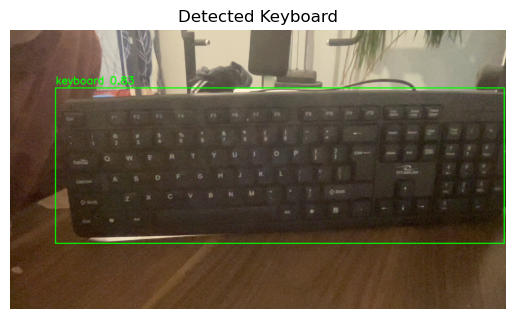

(117, 149, 1275, 550)
(4, 256, 256)


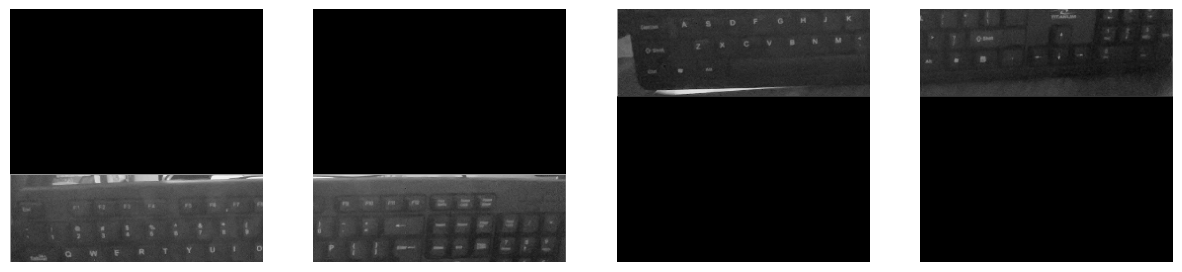

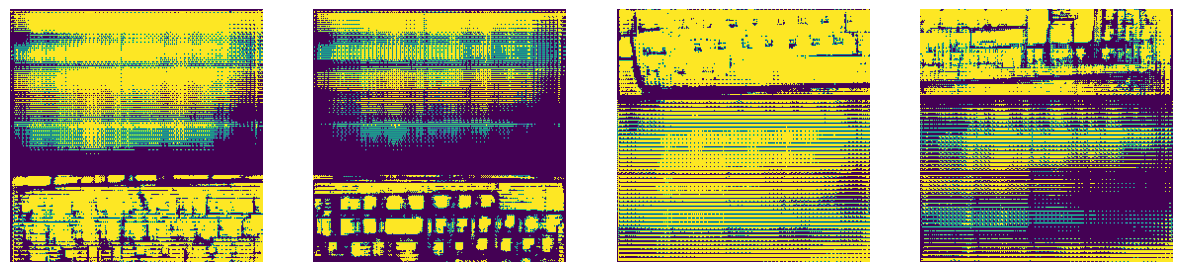

(512, 512)
(512, 512, 3)

0: 384x640 1 person, 1 chair, 119.5ms
Speed: 2.7ms preprocess, 119.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 122.3ms
Speed: 1.1ms preprocess, 122.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 1 chair, 116.1ms
Speed: 1.2ms preprocess, 116.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 118.7ms
Speed: 1.1ms preprocess, 118.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 120.0ms
Speed: 1.1ms preprocess, 120.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 118.5ms
Speed: 1.5ms preprocess, 118.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 121.1ms
Speed: 1.0ms preprocess, 121.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 119.

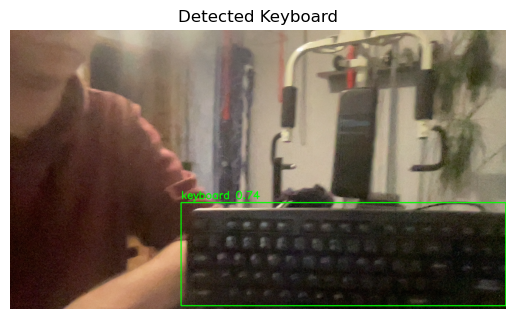

(441, 445, 1279, 711)
(4, 256, 256)


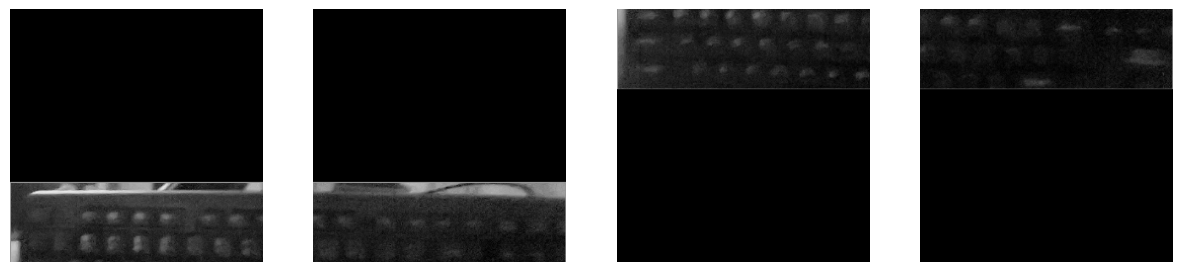

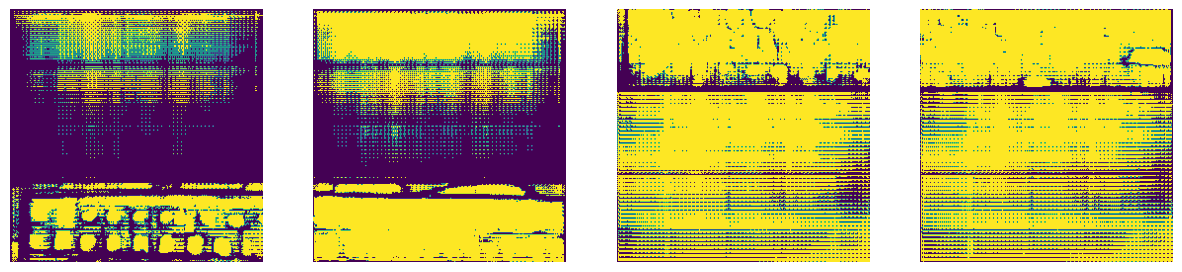

(512, 512)
(512, 512, 3)

0: 384x640 1 keyboard, 122.6ms
Speed: 3.4ms preprocess, 122.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


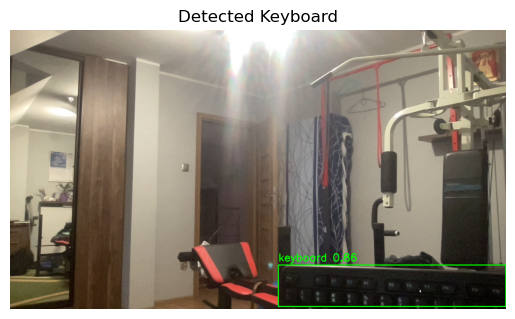

(692, 606, 1279, 713)
(4, 256, 256)


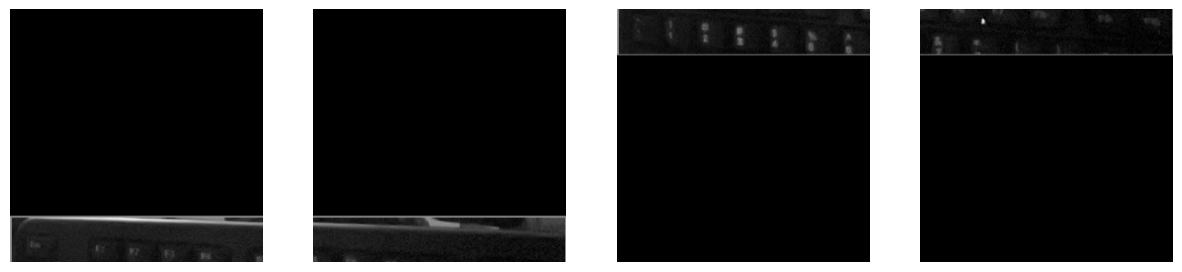

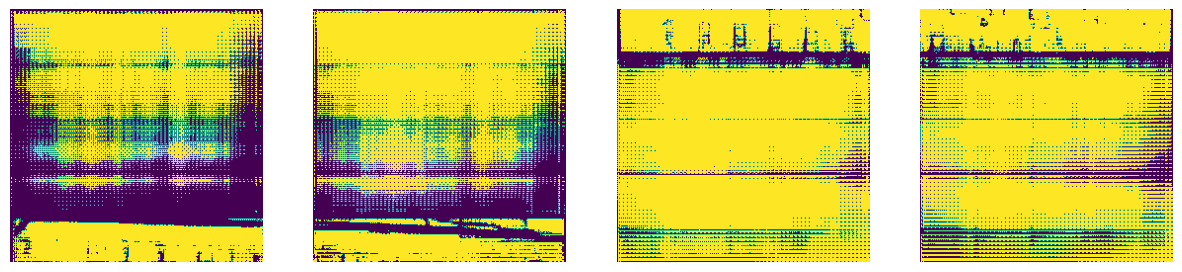

(512, 512)
(512, 512, 3)

0: 384x640 2 chairs, 1 potted plant, 1 keyboard, 128.5ms
Speed: 2.5ms preprocess, 128.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


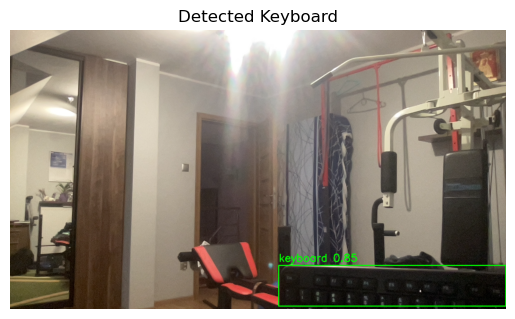

(693, 607, 1279, 712)
(4, 256, 256)


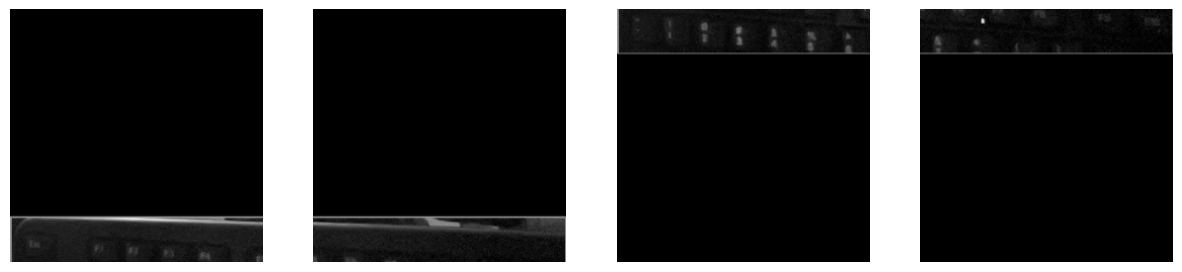

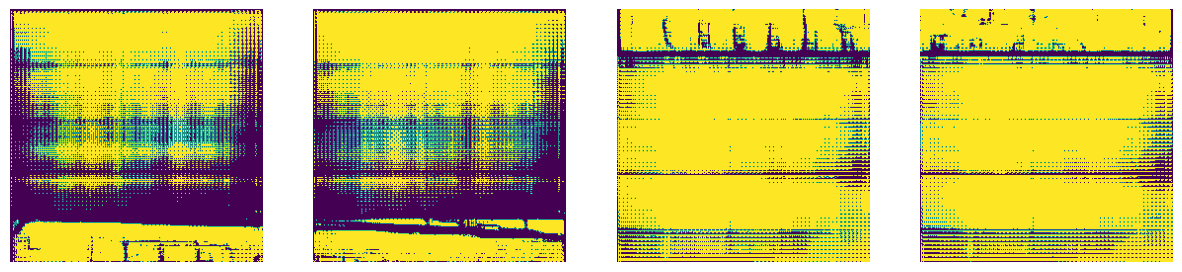

(512, 512)
(512, 512, 3)

0: 384x640 1 potted plant, 1 keyboard, 125.9ms
Speed: 2.6ms preprocess, 125.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


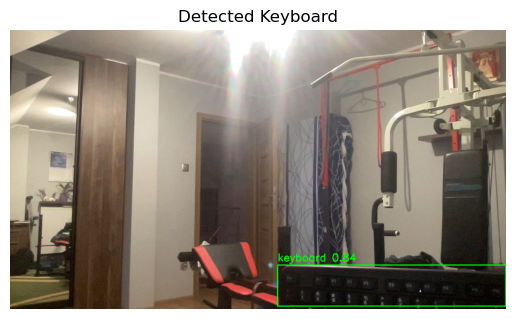

(690, 606, 1279, 712)
(4, 256, 256)


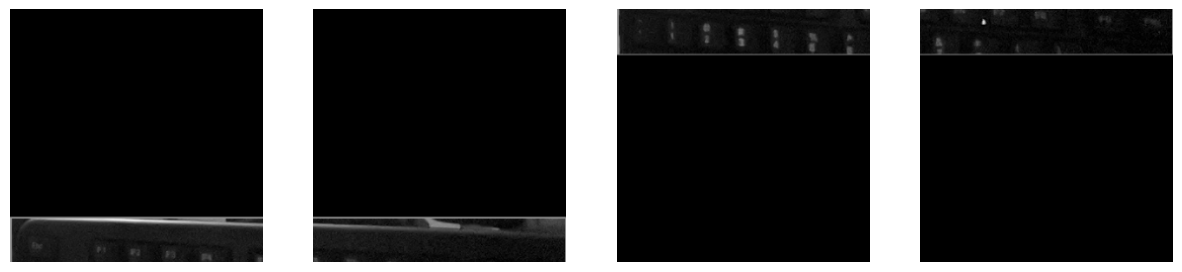

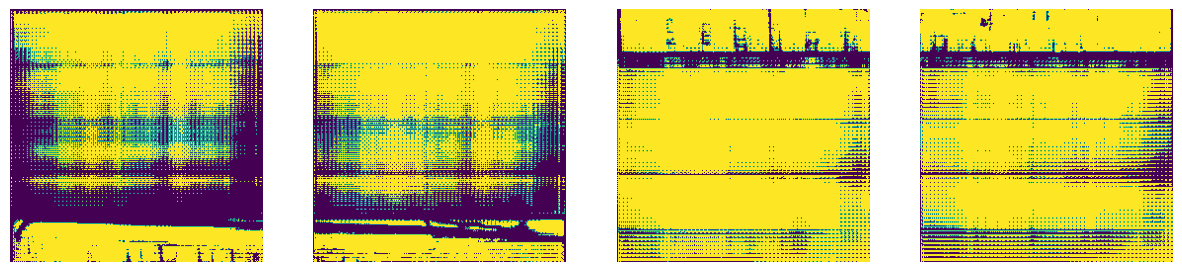

(512, 512)
(512, 512, 3)

0: 384x640 1 keyboard, 129.6ms
Speed: 4.2ms preprocess, 129.6ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)


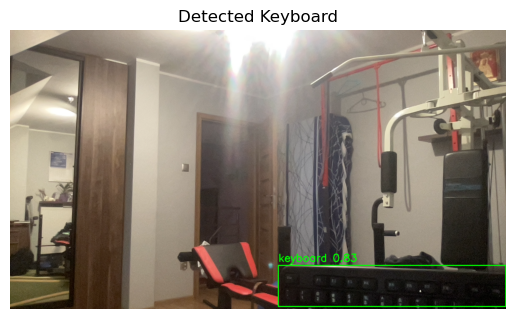

(692, 607, 1279, 713)
(4, 256, 256)


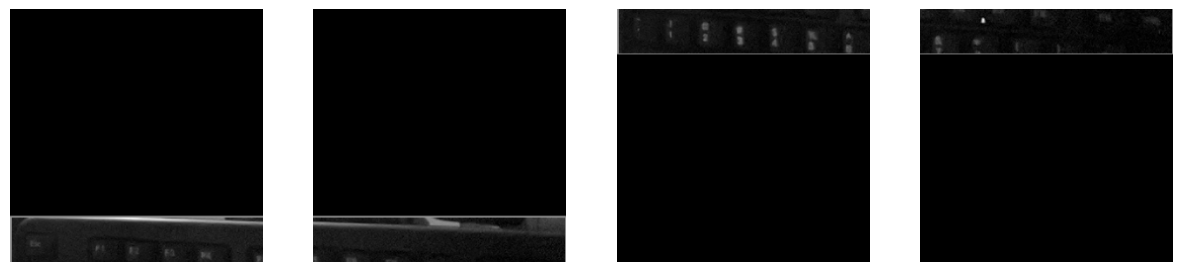

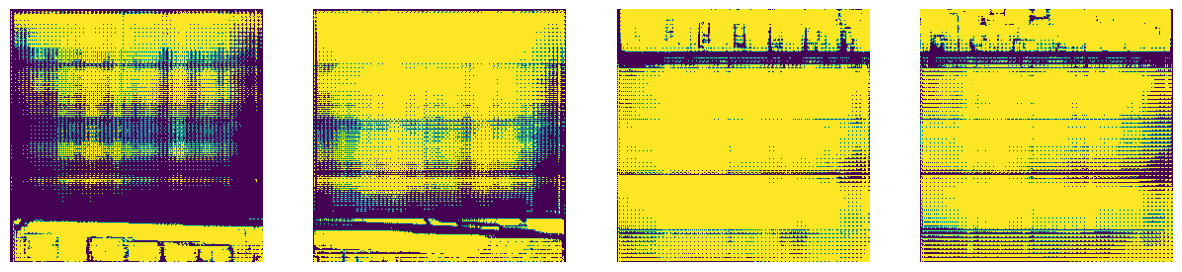

(512, 512)
(512, 512, 3)

0: 384x640 1 chair, 1 potted plant, 1 keyboard, 137.6ms
Speed: 4.7ms preprocess, 137.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


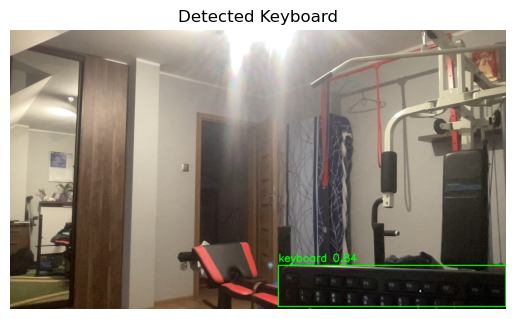

(692, 607, 1279, 713)
(4, 256, 256)


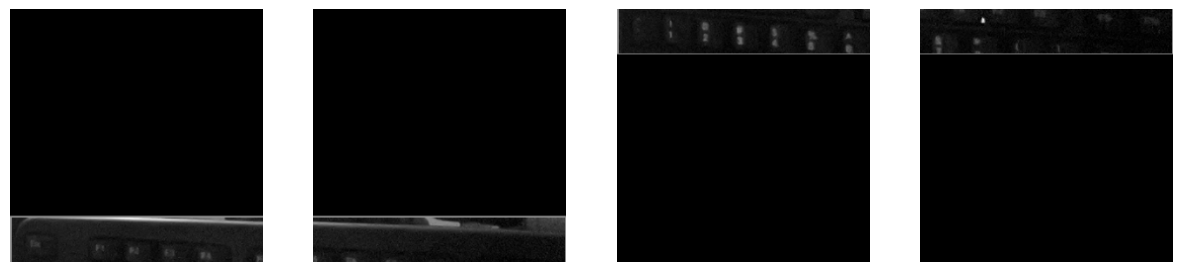

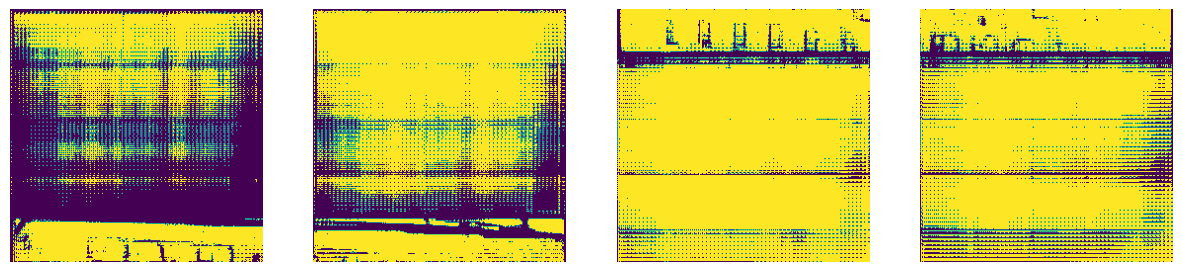

(512, 512)
(512, 512, 3)

0: 384x640 1 person, 174.5ms
Speed: 5.9ms preprocess, 174.5ms inference, 16.3ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 104.5ms
Speed: 1.3ms preprocess, 104.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 113.3ms
Speed: 1.2ms preprocess, 113.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
None

0: 384x640 1 person, 1 cup, 185.1ms
Speed: 1.2ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
None


: 

In [ ]:
import cv2
import time

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

while True:
    ret, frame = cam.read()
    cv2.imshow('Camera', frame)

    bbox = keyboard_bbox(frame)
    print(bbox)
    if bbox is not None:
        patches = transform_image(frame, bbox)
        mask = mask_from_patches(patches, key_det_model, processor, input_points)
        bbox_im = bbox_img(frame, bbox)
        print(mask.shape)
        print(bbox_im.shape)
        # Combine mask and bbox_im into a single picture with 3 classes
        combined_mask = np.zeros_like(bbox_im)
        combined_mask[np.all(bbox_im == [255, 255, 255], axis=-1)] = [0, 255, 0]  # Green for bbox
        combined_mask[mask == 1] = [255, 0, 0]

        x1, y1, x2, y2 = bbox  # Bounding box coordinates
        bbox_width = x2 - x1   # Width of bbox
        bbox_height = y2 - y1  # Height of bbox
    
        # Get dimensions of combined_mask
        mask_h, mask_w, _ = combined_mask.shape  # (height, width, channels)
    
        # Compute vertical cropping
        center_y = mask_h // 2  # Center of combined_mask vertically
        y_start = max(center_y - bbox_height // 2, 0)
        y_end = min(center_y + bbox_height // 2, mask_h)
    
        # Crop vertically, keeping full width
        cropped_mask = combined_mask[y_start:y_end, :, :]  # (bbox_height, full_mask_width, 3)
    
        # If the height is different by 1 pixel, adjust it to match bbox_height
        if cropped_mask.shape[0] != bbox_height:
            if cropped_mask.shape[0] < bbox_height:
                # Pad if cropped_mask is smaller than bbox_height
                pad_top = (bbox_height - cropped_mask.shape[0]) // 2
                pad_bottom = bbox_height - cropped_mask.shape[0] - pad_top
                cropped_mask = cv2.copyMakeBorder(cropped_mask, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
            else:
                # Crop if cropped_mask is larger than bbox_height
                cropped_mask = cropped_mask[:bbox_height, :, :]
    
        # If bbox is wider than the cropped mask, we need to pad the mask
        if mask_w < bbox_width:
            # Compute padding on left & right
            pad_left = (bbox_width - mask_w) // 2
            pad_right = bbox_width - mask_w - pad_left
    
            # Pad with zeros (black)
            cropped_mask = cv2.copyMakeBorder(cropped_mask, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
        # Ensure overlay is the same shape as frame
        overlay = np.zeros_like(frame)
    
        # Place the cropped mask at the correct location in overlay
        overlay[y1:y2, x1:x2] = cropped_mask  # Only placing inside bbox
    
        # Blend overlay with frame
        alpha = 0.5  # Transparency factor
        frame = cv2.addWeighted(frame, 1, overlay, alpha, 0)

    # Display the captured frame
    cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
out.release()
cv2.destroyAllWindows()